In [1]:
import numpy as np
from scipy.stats import beta
from scipy import stats
from ridgereliability import plots, metrics
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from functools import partial
import tabulate
import sklearn.model_selection

In [2]:
np.random.seed(42)

In [3]:
def find_beta_distribution(mean, var):
    """
    Find parameters for a beta distribution with mean m and variance var.
    """

    v = (mean*(1-mean)/var)-1
    a = mean*v
    b = (1-mean)*v

    return a, b


def get_diagram_data(n_bins, var_per_bin):

    accuracy = np.empty((n_bins,), dtype=float)
    dists = np.empty((n_bins, 2), dtype=int)
    y_probs = []
    y_true = []
    y_preds = []

    confidence_levels = np.array([0.5/n_bins+i/n_bins for i in range(n_bins)])

    diff = 0.
    for i, c in enumerate(confidence_levels):

        dists[i] = find_beta_distribution(c, var_per_bin)
        
        preds = np.random.choice(a=[False, True], size=sum(dists[i])-2)
        n_flip = dists[i, 1]-1
        true = preds.copy()
        idx = np.random.choice(len(true), size=n_flip, replace=False)
        true[idx] = ~true[idx]

        accuracy[i] = (preds == true).mean()
        probs = np.full((len(preds),), fill_value=accuracy[i])

        y_probs.extend(list(probs))
        y_true.extend(list(true))
        y_preds.extend(list(preds))

    return accuracy, dists, np.array(y_probs), np.array(y_preds).astype(int), np.array(y_true).astype(int)


def set_anchored_text(text, ax):
    at = AnchoredText(text,
            prop=dict(size=12, family='DejaVu Sans Mono'), frameon=True,
            loc='lower right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    at.zorder = 100
    ax.add_artist(at)

In [4]:
n_bins = 10

var1 = 0.0001
var2 = 0.001

ci = [0.9, 0.95, 0.99]

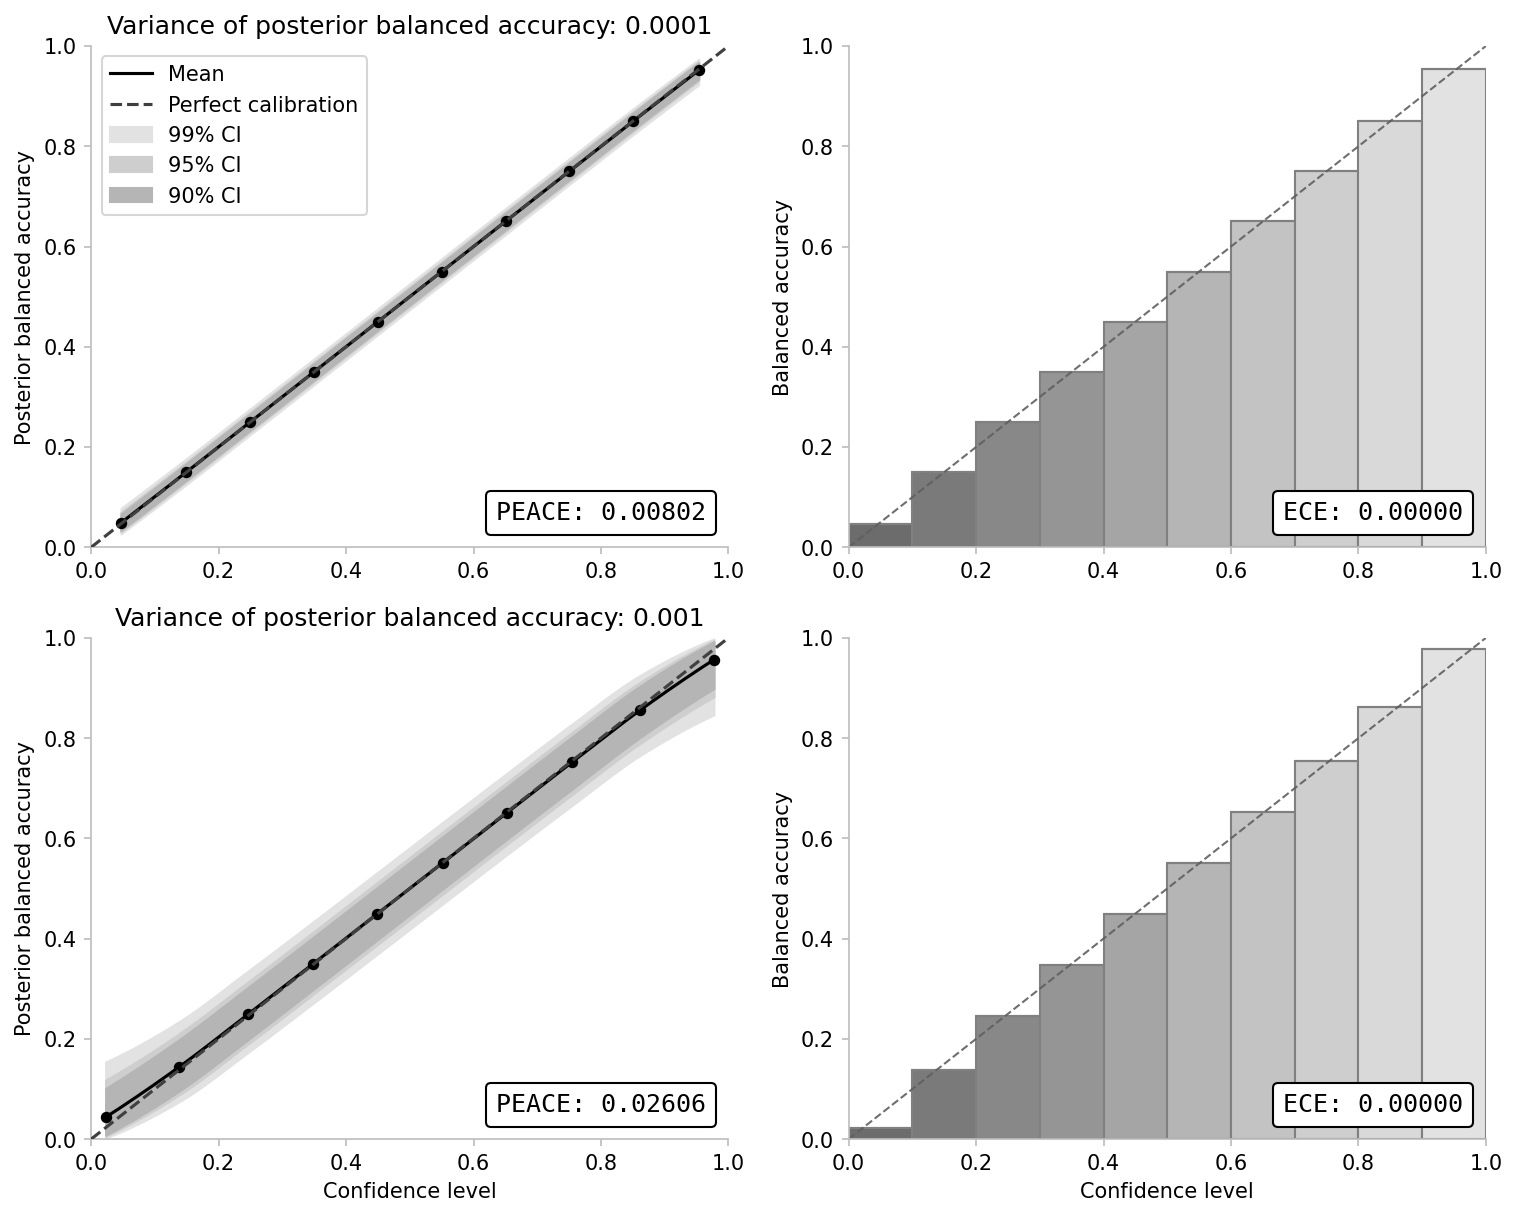

In [8]:
data1 = get_diagram_data(n_bins, var1)
data2 = get_diagram_data(n_bins, var2)

fig, axes = plt.subplots(2, 2, dpi=150, figsize=(10, 8), constrained_layout=True) 

plots.river_diagram(data1[1], data1[0], axes[0, 0], ci)
plots.river_diagram(data2[1], data2[0], axes[1, 0], ci)

edges = np.array([i/n_bins for i in range(n_bins+1)])
plots.bar_diagram(edges, data1[0], data1[0], ax=axes[0, 1])
plots.bar_diagram(edges, data2[0], data2[0], ax=axes[1, 1])

plots._decorate_ax(axes[0, 1])
plots._decorate_ax(axes[1, 1])

axes[1, 0].set_ylabel("Posterior balanced accuracy")
axes[0, 0].set_ylabel("Posterior balanced accuracy")
axes[0, 1].set_ylabel("Balanced accuracy")
axes[1, 1].set_ylabel("Balanced accuracy")
axes[1, 1].set_xlabel("Confidence level")
axes[1, 0].set_xlabel("Confidence level")

axes[0,0].legend()

axes[0, 0].set_title(f"Variance of posterior balanced accuracy: {var1}")
axes[1, 0].set_title(f"Variance of posterior balanced accuracy: {var2}")

set_anchored_text("PEACE: %.5f" % metrics.peace(*data1[-3:], bins=n_bins), axes[0, 0])
set_anchored_text("PEACE: %.5f" % metrics.peace(*data2[-3:], bins=n_bins), axes[1, 0])
set_anchored_text("ECE: %.5f" % metrics.ece(*data1[-3:], bins=n_bins), axes[0, 1])
set_anchored_text("ECE: %.5f" % metrics.ece(*data2[-3:], bins=n_bins), axes[1, 1])

plt.savefig("variance.pdf")